In [1]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from PIL import Image

import torch
#import torchtext
import random
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
#from torchvision import transforms, utils
#from torchvision.transforms import Resize, ToTensor, Normalize
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

from albumentations.pytorch import transforms
import albumentations as A
import cv2

In [2]:
def set_seed(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True

seed = 42
set_seed(seed)

In [3]:
train_path = '/opt/ml/input/data/train'
train_image_dir_path = os.path.join(train_path, 'images')

In [4]:
# images 디렉토리안의 디렉토리 가져옴
dir_list = [i_dir for i_dir in os.listdir(train_image_dir_path) if i_dir[0] != '.']
len(dir_list)

2700

In [5]:
dir_df = pd.DataFrame(dir_list, columns = ['dir_path'])

In [6]:
# 디렉토리 이름만 가지고 라벨링, 마스크여부랑 상관없이 gender, age 만 가지고 라벨링
def dir_labeling(name):
    label = 0
    info = name.split('_')
    gender, age = info[1], int(info[3])
    if gender == 'female':
        label += 3
    
    if 30 <= age < 60:
        label += 1
    elif age >= 60:
        label += 2

    return label

In [7]:
dir_df['label'] = dir_df['dir_path'].map(lambda X : dir_labeling(X))
print(dir_df.shape)
dir_df[:5]

(2700, 2)


,dir_path,label
0,001401_male_Asian_48,1
1,003439_male_Asian_58,1
2,003871_female_Asian_57,4
3,001661_female_Asian_45,4
4,004384_female_Asian_60,5


In [8]:
# 사람이 겹치지 않게 train, valid 나눔
from sklearn.model_selection import train_test_split
train_dirs, valid_dirs = train_test_split(dir_df, test_size= 0.1, 
                                shuffle = True, stratify= dir_df['label'], 
                                random_state = seed)

In [9]:
train_dirs.shape, valid_dirs.shape

((2430, 2), (270, 2))

In [10]:
# 디렉토리안의 파일을 가져옴
def make_each_path(dirs):
    result = []
    for image_path in list(dirs['dir_path']):
        d_name = os.path.join(train_image_dir_path, image_path)
        filenames = os.listdir(d_name)
        for filename in filenames:
            if filename[0] == '.':
                continue
            full_file_name = os.path.join(d_name, filename)
            result.append(full_file_name)
    return result

In [11]:
# train의 파일 
train_path = make_each_path(train_dirs)
print(len(train_path))
#train_path[:10]

17010


In [14]:
# valid의 파일
valid_path = make_each_path(valid_dirs)
len(valid_path)

1890

In [15]:
train_path_label = pd.DataFrame(train_path, columns = ['path'])
valid_path_label = pd.DataFrame(valid_path, columns = ['path'])

In [16]:
# 파일을 라벨링
def labeling(name):
    label = 0
    info, mask_type = name.split('/')[-2:]
    info = info.split('_')
    gender, age = info[1], int(info[3])
    if 'incorrect' in mask_type:
        label += 6
    elif 'normal' in mask_type:
        label += 12
    
    if gender == 'female':
        label += 3
        
    if 30 <= age < 60:
        label += 1
    elif age >= 60:
        label += 2
    
    return label

In [17]:
train_path_label['label'] = train_path_label['path'].map(lambda x : labeling(x))
valid_path_label['label'] = valid_path_label['path'].map(lambda x : labeling(x))

In [18]:
train_path_label[:3]

,path,label
0,/opt/ml/input/data/train/images/000732_female_...,16
1,/opt/ml/input/data/train/images/000732_female_...,10
2,/opt/ml/input/data/train/images/000732_female_...,4


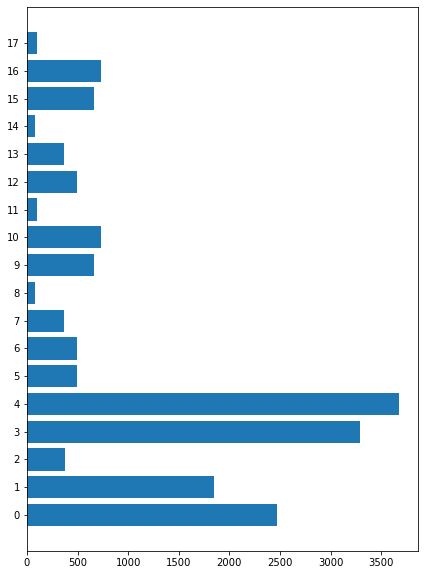

In [19]:
# train 데이터의 클래스 별 개수
train_counts = train_path_label['label'].value_counts(dropna=False).sort_index().to_frame() #/ len(train_path_label) * 100
plt.figure(figsize = (7, 10))
plt.barh(train_counts.index, train_counts['label'])
plt.yticks(range(18));

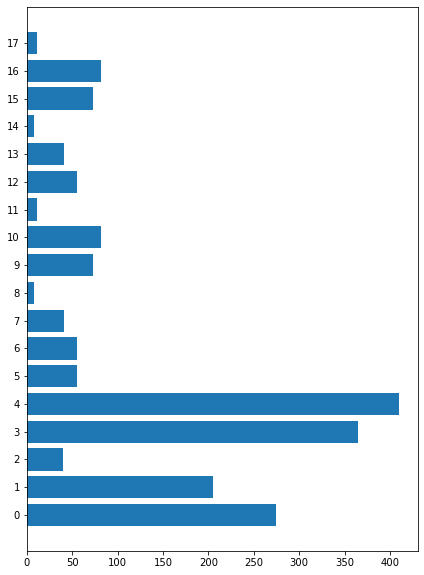

In [20]:
# valid의 클래스별 개수
valid_counts = valid_path_label['label'].value_counts(dropna=False).sort_index().to_frame()
plt.figure(figsize = (7, 10))
plt.barh(valid_counts.index, valid_counts['label'])
plt.yticks(range(18));

In [45]:
# 4, 3, 1, 0    1000개 까지 줄여보기 -> random sample
# 17, 14, 11, 8    5배 -> path를 복사하고 transform 여부 주기
# 16, 15, 13, 12, 10, 9, 7, 6, 5, 2,   2배 -> path를 복사하고 transform 여부 주기

# -> 이 데이터들을 합쳐서 쓸거다.

In [362]:
# augmentation 여부를 is_aug라는 column만들어서 표시
train_path_label['is_aug'] = 0
train_path_label

,path,label,is_aug
0,/opt/ml/input/data/train/images/000732_female_...,16,0
1,/opt/ml/input/data/train/images/000732_female_...,10,0
2,/opt/ml/input/data/train/images/000732_female_...,4,0
3,/opt/ml/input/data/train/images/000732_female_...,4,0
4,/opt/ml/input/data/train/images/000732_female_...,4,0
...,...,...,...
17005,/opt/ml/input/data/train/images/005146_female_...,4,0
17006,/opt/ml/input/data/train/images/005146_female_...,4,0
17007,/opt/ml/input/data/train/images/005146_female_...,4,0
17008,/opt/ml/input/data/train/images/005146_female_...,4,0


In [382]:
# 0, 1, 3, 4, data 1000개까지 줄임
down_label_4_df = train_path_label[train_path_label['label']==4].sample(n=1000, random_state=seed)
down_label_3_df = train_path_label[train_path_label['label']==3].sample(n=1000, random_state=seed)
down_label_1_df = train_path_label[train_path_label['label']==1].sample(n=1000, random_state=seed)
down_label_0_df = train_path_label[train_path_label['label']==0].sample(n=1000, random_state=seed)

# 각각 1000개 까지 줄인 데이터를 합침
down_df = pd.concat([down_label_4_df, down_label_3_df, down_label_1_df, down_label_0_df])
down_df.shape

(4000, 3)

In [384]:
# augmentation 할 데이터들, 5배하는거랑 2배 하는거 만들고 합침, is_aug = 1 로 설정
mul_5 = [8, 11, 14, 17]
mul_2 = [2, 5, 6, 7, 9, 10, 12, 13, 15, 16]

mul_5_each_df = train_path_label[train_path_label['label'].isin(mul_5)]
mul_2_each_df = train_path_label[train_path_label['label'].isin(mul_2)]
print(mul_5_each_df.shape, mul_2_each_df.shape)

mul_5_df = pd.concat([mul_5_each_df, mul_5_each_df, mul_5_each_df, mul_5_each_df, mul_5_each_df])
mul_2_df = pd.concat([mul_2_each_df, mul_2_each_df])
print(mul_5_df.shape, mul_2_df.shape)
mul_df = pd.concat([mul_5_df, mul_2_df])
mul_df.loc[:,'is_aug'] = 1
mul_df.shape

(346, 3) (5379, 3)
(1730, 3) (10758, 3)


(12488, 3)

In [387]:
# 줄이거나 늘린 데이터 path를 합침
# is_aug가 1인 녀석들은 transform을 이용해서 원본에 조금 변화를 줄것이다
train_path_label_aug = pd.concat([down_df, mul_df], ignore_index = True)
train_path_label_aug = train_path_label_aug.sample(frac=1).reset_index(drop=True) # shuffle
print(train_path_label_aug.shape)
train_path_label_aug[:10]

(16488, 3)


,path,label,is_aug
0,/opt/ml/input/data/train/images/001461_female_...,16,1
1,/opt/ml/input/data/train/images/004273_female_...,10,1
2,/opt/ml/input/data/train/images/005073_female_...,16,1
3,/opt/ml/input/data/train/images/004080_female_...,5,1
4,/opt/ml/input/data/train/images/006516_male_As...,12,1
5,/opt/ml/input/data/train/images/001457_male_As...,7,1
6,/opt/ml/input/data/train/images/004272_male_As...,1,0
7,/opt/ml/input/data/train/images/006513_male_As...,0,0
8,/opt/ml/input/data/train/images/001226_male_As...,12,1
9,/opt/ml/input/data/train/images/004439_female_...,9,1


In [408]:
# valid는 is)aug 0으로 줌
valid_path_label['is_aug'] = 0
valid_path_label[:10]

,path,label,is_aug
0,/opt/ml/input/data/train/images/006171_female_...,3,0
1,/opt/ml/input/data/train/images/006171_female_...,3,0
2,/opt/ml/input/data/train/images/006171_female_...,3,0
3,/opt/ml/input/data/train/images/006171_female_...,9,0
4,/opt/ml/input/data/train/images/006171_female_...,15,0
5,/opt/ml/input/data/train/images/006171_female_...,3,0
6,/opt/ml/input/data/train/images/006171_female_...,3,0
7,/opt/ml/input/data/train/images/001827_male_As...,12,0
8,/opt/ml/input/data/train/images/001827_male_As...,6,0
9,/opt/ml/input/data/train/images/001827_male_As...,0,0


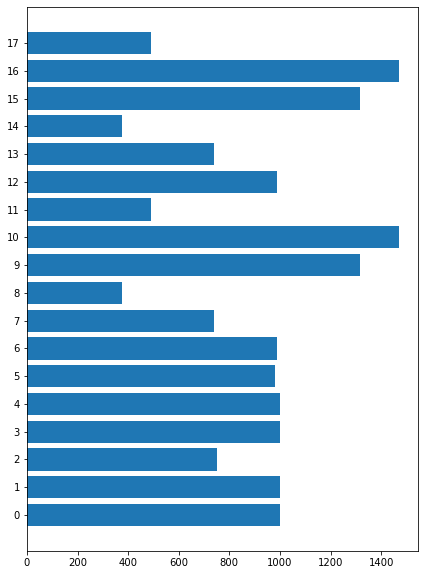

In [425]:
# aug 하고난 뒤 class별 개수
train_counts = train_path_label_aug['label'].value_counts(dropna=False).sort_index().to_frame() #/ len(train_path_label) * 100
plt.figure(figsize = (7, 10))
plt.barh(train_counts.index, train_counts['label'])
plt.yticks(range(18));

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


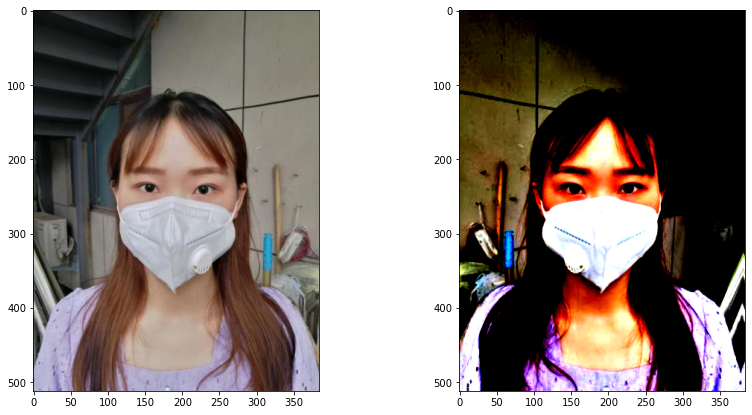

In [399]:
'''
p = 0.5
transform = A.Compose([
		# 변환할 함수들 리스트
    A.Resize(512, 384),
    A.HorizontalFlip(p=p),
    A.Rotate(limit=7, p=p),
    A.RandomBrightnessContrast(0.1, p=p),
    A.RandomGamma(gamma_limit=(80,120), p=p),
    #A.pytorch.transforms.ToTensorV2(transpose_mask=True)
    A.Normalize(mean=0.5, std=0.2),
    #transforms.ToTensorV2(transpose_mask=True)
    #A.CenterCrop(height=300, width=300, p=1)
])

image = cv2.imread(train_path_label['path'][200])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#image = Image.open(train_path_label['path'][200])

transformed = transform(image=image)


plt.figure(figsize = (14,7))
plt.subplot(1,2,1)
plt.imshow(image)

plt.subplot(1,2,2)
transformed_image = transformed['image']
#transformed_image.shape
plt.imshow(transformed_image)
'''

In [409]:
# is_aug 여부에 따라 transform이 달라지기에 2개의 transform을 받는다
# 하나는 일반용, 하나는 aug용
class CustomAugDataset(Dataset):
    def __init__(self, img_paths_label, transform, aug_transform = None):
        self.X = img_paths_label['path']
        self.y = img_paths_label['label']
        self.aug_check = img_paths_label['is_aug']
        self.transform = transform
        self.aug_transform = aug_transform

    def __getitem__(self, index):
        image = cv2.imread(self.X.iloc[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.y.iloc[index]
        
        if self.aug_check.iloc[index] == 1:
            transformed = self.aug_transform(image = image)
        else:
            transformed = self.transform(image = image)
        
        transformed_image = transformed['image']
        return transformed_image, torch.tensor(label)

    def __len__(self):
        return len(self.X)

In [410]:
# aug용 transform
p = 0.5
aug_transform = A.Compose([
    A.Resize(512, 384),
    A.HorizontalFlip(p=p), # 좌우 대칭, p는 확률로 1이면 항상 하는것
    A.Rotate(limit=7, p=p), # 회전, 최고를 7도로 줌
    A.RandomBrightnessContrast(0.1, p=p), # 밝기?
    A.RandomGamma(gamma_limit=(80,120), p=p), # 잘 모르겠지만 밝기좀 변함, limit 잘 조정해야한다
    A.Normalize(mean=0.5, std=0.2), # 정규화, 이상하게 albutation은 텐서로 바꾸기전에 이미지에 정규화 때린다.
    transforms.ToTensorV2(transpose_mask=True) # tensor로 변형, transpose_mask 해야 C, H W로 나옴
    #A.CenterCrop(height=300, width=300, p=1) # crop, 나중에 시도해봐야지
])

# 일반용 transform
transform = A.Compose([
    A.Resize(512, 384),
    A.Normalize(mean=0.5, std=0.2),
    transforms.ToTensorV2(transpose_mask=True)
    #A.CenterCrop(height=300, width=300, p=1)
])

In [411]:
BATCH_SIZE = 64

train_dataset = CustomAugDataset(train_path_label_aug, transform, aug_transform)
train_dataloader = DataLoader(train_dataset, 
                        batch_size = BATCH_SIZE, 
                        shuffle = True
                       )

valid_dataset = CustomAugDataset(valid_path_label, transform)
valid_dataloader = DataLoader(valid_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = True
                             )

In [412]:
next(iter(train_dataloader))[0].shape

torch.Size([64, 3, 512, 384])

In [413]:
next(iter(valid_dataloader))[0].shape

torch.Size([64, 3, 512, 384])

In [414]:
# resnet18을 베이스로 만든 모델
# 출력뒤에 18개의 output을 뱉는 fc층만 추가함
# 그 추가한 층은 xavier 초기화
class TunedResnet18(nn.Module):
    def __init__(self, num_classes: int = 1000):
        super().__init__()
        self.model = torchvision.models.resnet18(pretrained=True)
        self.fc_to_fc2_dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1000, num_classes)
        self.init_param()
        
    def init_param(self):
        # xavier uniform
        torch.nn.init.xavier_uniform_(self.fc2.weight) 
        stdv = 1. / math.sqrt(self.fc2.weight.size(1))
        self.fc2.bias.data.uniform_(-stdv, stdv)
        
    def forward(self,x):
        x = self.model(x)
        x = F.relu(x)
        x = self.fc_to_fc2_dropout(x)
        return self.fc2(x)

In [415]:
resnet18 = TunedResnet18(num_classes = 18)

In [52]:
# resnet18 = torchvision.models.resnet18(pretrained=True)

# OUTPUT_CLASS_NUM = 18
# resnet18.fc = torch.nn.Linear(in_features = 512, out_features = OUTPUT_CLASS_NUM, bias = True) # output 18개로

# # xavier uniform
# torch.nn.init.xavier_uniform_(resnet18.fc.weight) 
# stdv = 1. / math.sqrt(resnet18.fc.weight.size(1))
# resnet18.fc.bias.data.uniform_(-stdv, stdv)

# resnet18.fc.weight.shape[0]

18

In [416]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [417]:
resnet18.to(device)

LEARNING_RATE = 0.0001 # 학습 때 사용하는 optimizer의 학습률 옵션 설정
NUM_EPOCH = 10 # 학습 때 mnist train 데이터 셋을 얼마나 많이 학습할지 결정하는 옵션
OUTPUT_CLASS_NUM = 18

#f1_loss = F1_Loss(class_num=OUTPUT_CLASS_NUM)
loss_fn = torch.nn.CrossEntropyLoss() # 분류 학습 때 많이 사용되는 Cross entropy loss를 objective function으로 사용 - https://en.wikipedia.org/wiki/Cross_entropy
optimizer = torch.optim.Adam(resnet18.parameters(), lr=LEARNING_RATE) # weight 업데이트를 위한 optimizer를 Adam으로 사용함

dataloaders = {
    "train" : train_dataloader,
    "test" : valid_dataloader
}

In [418]:
best_test_accuracy = 0.
best_test_loss = 9999.
model_saved = "./saved3"

for epoch in range(NUM_EPOCH):
    for phase in ["train", "test"]:
        running_loss = 0.
        running_acc = 0.
        if phase == "train":
            resnet18.train() # 네트워크 모델을 train 모드로 두어 gradient을 계산하고, 여러 sub module (배치 정규화, 드롭아웃 등)이 train mode로 작동할 수 있도록 함
        elif phase == "test":
            resnet18.eval() # 네트워크 모델을 eval 모드 두어 여러 sub module들이 eval mode로 작동할 수 있게 함
        
        for ind, (images, labels) in enumerate(dataloaders[phase]):
            images = images.to(device)
            labels = labels.to(device)
        
            optimizer.zero_grad() # parameter gradient를 업데이트 전 초기화함

            with torch.set_grad_enabled(phase == "train"): # train 모드일 시에는 gradient를 계산하고, 아닐 때는 gradient를 계산하지 않아 연산량 최소화
                logits = resnet18(images)
                _, preds = torch.max(logits, 1) # 모델에서 linear 값으로 나오는 예측 값 ([0.9,1.2, 3.2,0.1,-0.1,...])을 최대 output index를 찾아 예측 레이블([2])로 변경함  
                loss = loss_fn(logits, labels)

                if phase == "train":
                    loss.backward() # 모델의 예측 값과 실제 값의 CrossEntropy 차이를 통해 gradient 계산
                    optimizer.step() # 계산된 gradient를 가지고 모델 업데이트

            running_loss += loss.item() * images.size(0) # 한 Batch에서의 loss 값 저장
            running_acc += torch.sum(preds == labels.data) # 한 Batch에서의 Accuracy 값 저장

        # 한 epoch이 모두 종료되었을 때,
        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_acc / len(dataloaders[phase].dataset)

        print(f"현재 epoch-{epoch}의 {phase}-데이터 셋에서 평균 Loss : {epoch_loss:.3f}, 평균 Accuracy : {epoch_acc:.3f}")
        if phase == "test" and best_test_accuracy < epoch_acc: # phase가 test일 때, best accuracy 계산
            best_test_accuracy = epoch_acc
            os.makedirs(model_saved, exist_ok=True)
            torch.save(resnet18, f"{model_saved}/accr_resnet18_CEloss_batchsize:{BATCH_SIZE}_lr:{LEARNING_RATE}.pt")
        if phase == "test" and best_test_loss > epoch_loss: # phase가 test일 때, best loss 계산
            best_test_loss = epoch_loss
            os.makedirs(model_saved, exist_ok=True)
            torch.save(resnet18, f"{model_saved}/loss_resnet18_CEloss_batchsize:{BATCH_SIZE}_lr:{LEARNING_RATE}.pt")
            
print("학습 종료!")
print(f"최고 accuracy : {best_test_accuracy}, 최고 낮은 loss : {best_test_loss}")

현재 epoch-0의 train-데이터 셋에서 평균 Loss : 0.806, 평균 Accuracy : 0.743
현재 epoch-0의 test-데이터 셋에서 평균 Loss : 0.414, 평균 Accuracy : 0.862
현재 epoch-1의 train-데이터 셋에서 평균 Loss : 0.169, 평균 Accuracy : 0.946
현재 epoch-1의 test-데이터 셋에서 평균 Loss : 0.468, 평균 Accuracy : 0.854
현재 epoch-2의 train-데이터 셋에서 평균 Loss : 0.067, 평균 Accuracy : 0.981
현재 epoch-2의 test-데이터 셋에서 평균 Loss : 0.489, 평균 Accuracy : 0.867
현재 epoch-3의 train-데이터 셋에서 평균 Loss : 0.047, 평균 Accuracy : 0.986
현재 epoch-3의 test-데이터 셋에서 평균 Loss : 0.516, 평균 Accuracy : 0.892
현재 epoch-4의 train-데이터 셋에서 평균 Loss : 0.030, 평균 Accuracy : 0.991
현재 epoch-4의 test-데이터 셋에서 평균 Loss : 0.547, 평균 Accuracy : 0.883
현재 epoch-5의 train-데이터 셋에서 평균 Loss : 0.014, 평균 Accuracy : 0.996
현재 epoch-5의 test-데이터 셋에서 평균 Loss : 0.606, 평균 Accuracy : 0.879
현재 epoch-6의 train-데이터 셋에서 평균 Loss : 0.019, 평균 Accuracy : 0.994
현재 epoch-6의 test-데이터 셋에서 평균 Loss : 0.894, 평균 Accuracy : 0.829
현재 epoch-7의 train-데이터 셋에서 평균 Loss : 0.033, 평균 Accuracy : 0.990
현재 epoch-7의 test-데이터 셋에서 평균 Loss : 0.746, 평균 Accuracy : 0.843


In [419]:
# loss가 가장 낮았을때 모델 불러옴
# 이 모델이 test 에게 좋게 동작함
resnet18_best_CEloss = torch.load(f"{model_saved}/loss_resnet18_CEloss_batchsize:{BATCH_SIZE}_lr:{LEARNING_RATE}.pt")

In [420]:
# acc가 가장 높았을때 모델 불러옴
resnet18_best_acc = torch.load(f"{model_saved}/accr_resnet18_CEloss_batchsize:{BATCH_SIZE}_lr:{LEARNING_RATE}.pt")

In [89]:
# def func_eval(model, data_iter, device):
#     with torch.no_grad():
#         n_total, n_correct = 0,0
#         model.eval()
#         for batch_in, batch_out in data_iter:
#             y_trgt = batch_out.to(device)
#             model_pred = model.forward(batch_in.to(device))
#             _, y_pred = torch.max(model_pred, 1) # 행으로 비교
#             n_correct += (y_pred == y_trgt).sum().item()
#             n_total += batch_in.size(0)
#         val_accr = (n_correct/n_total)
#         #model.train()
#     return val_accr

In [91]:
#func_eval(resnet18_use_CEloss, valid_dataloader, device)

0.8888888888888888

In [92]:
#func_eval(resnet18, valid_dataloader, device)

0.8936507936507937

In [421]:
def check_eval(raw_data, dataloader, model, device):
    result = []
    with torch.no_grad():
        model.eval()
        for i, (X,y) in enumerate(dataloader):
            model_pred = model.forward(X.to(device))
            _, y_pred = torch.max(model_pred, 1)

            result.append([raw_data.iloc[i]['path'], y_pred.cpu().numpy()[0], y.cpu().numpy()[0]])
    result = pd.DataFrame(result, columns=['path', 'pred', 'target'])
    return result

In [422]:
valid_testing_dataloader = DataLoader(valid_dataset, shuffle = False)

check_eval_loss_df = check_eval(valid_path_label, valid_testing_dataloader, resnet18_best_CEloss, device)
check_eval_loss_df

,path,pred,target
0,/opt/ml/input/data/train/images/006171_female_...,3,3
1,/opt/ml/input/data/train/images/006171_female_...,3,3
2,/opt/ml/input/data/train/images/006171_female_...,3,3
3,/opt/ml/input/data/train/images/006171_female_...,9,9
4,/opt/ml/input/data/train/images/006171_female_...,15,15
...,...,...,...
1885,/opt/ml/input/data/train/images/004027_male_As...,1,1
1886,/opt/ml/input/data/train/images/004027_male_As...,1,1
1887,/opt/ml/input/data/train/images/004027_male_As...,1,1
1888,/opt/ml/input/data/train/images/004027_male_As...,1,1


In [423]:
wrong_df = check_eval_loss_df[check_eval_loss_df['pred'] != check_eval_loss_df['target']]
wrong_df = wrong_df.reset_index(drop=True)
wrong_df

,path,pred,target
0,/opt/ml/input/data/train/images/005072_female_...,5,4
1,/opt/ml/input/data/train/images/005412_female_...,16,17
2,/opt/ml/input/data/train/images/005412_female_...,10,11
3,/opt/ml/input/data/train/images/005412_female_...,4,5
4,/opt/ml/input/data/train/images/005412_female_...,4,5
...,...,...,...
255,/opt/ml/input/data/train/images/001156_female_...,5,4
256,/opt/ml/input/data/train/images/001156_female_...,5,4
257,/opt/ml/input/data/train/images/005435_female_...,16,15
258,/opt/ml/input/data/train/images/004368_female_...,5,4


In [424]:
# loss가 가장 낮았을때 모델의 성능
# 결과적으론 이 모델이 test 데이터에서 가장 좋게동작함
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
print(f"f1 : {f1_score(check_eval_loss_df['target'], check_eval_loss_df['pred'], average = 'macro')}")
print(f"recall : {recall_score(check_eval_loss_df['target'], check_eval_loss_df['pred'], average = 'macro')}")
print(f"precision : {precision_score(check_eval_loss_df['target'], check_eval_loss_df['pred'], average = 'macro')}")

f1 : 0.7691530420151793
recall : 0.8204443533227362
precision : 0.7696187039508712


In [67]:
check_eval_accr_df = check_eval(valid_path_label, valid_testing_dataloader, resnet18_best_acc, device)
check_eval_accr_df

,path,pred,target
0,/opt/ml/input/data/train/images/000561_female_...,16,16
1,/opt/ml/input/data/train/images/000561_female_...,10,10
2,/opt/ml/input/data/train/images/000561_female_...,4,4
3,/opt/ml/input/data/train/images/000561_female_...,4,4
4,/opt/ml/input/data/train/images/000561_female_...,4,4
...,...,...,...
1885,/opt/ml/input/data/train/images/000590_male_As...,1,1
1886,/opt/ml/input/data/train/images/000590_male_As...,1,1
1887,/opt/ml/input/data/train/images/000590_male_As...,1,1
1888,/opt/ml/input/data/train/images/000590_male_As...,1,1


In [68]:
wrong_df = check_eval_accr_df[check_eval_accr_df['pred'] != check_eval_accr_df['target']]
wrong_df = wrong_df.reset_index(drop=True)
wrong_df

,path,pred,target
0,/opt/ml/input/data/train/images/000595_male_As...,10,7
1,/opt/ml/input/data/train/images/000595_male_As...,4,1
2,/opt/ml/input/data/train/images/000595_male_As...,4,1
3,/opt/ml/input/data/train/images/003889_female_...,15,16
4,/opt/ml/input/data/train/images/003889_female_...,9,10
...,...,...,...
162,/opt/ml/input/data/train/images/004339_female_...,10,11
163,/opt/ml/input/data/train/images/004339_female_...,4,5
164,/opt/ml/input/data/train/images/004339_female_...,4,5
165,/opt/ml/input/data/train/images/004339_female_...,4,5


In [71]:
# acc가 가장 높을때의 모델 성능
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
print(f"f1 : {f1_score(check_eval_accr_df['target'], check_eval_accr_df['pred'], average = 'macro')}")
print(f"recall : {recall_score(check_eval_accr_df['target'], check_eval_accr_df['pred'], average = 'macro')}")
print(f"precision : {precision_score(check_eval_accr_df['target'], check_eval_accr_df['pred'], average = 'macro')}")

f1 : 0.7901057152097009
recall : 0.7607375964793271
precision : 0.8535533483182629


In [31]:
# def draw_(df, col, wide, height):
#     plt.figure(figsize = (wide, height))
#     col = col
#     for i in range(df.shape[0]):
#         plt.subplot(df.shape[0]//col + 1, col , i+1)
#         plt.imshow(Image.open(df['path'][i]))
#         plt.title(f"target:{df['target'][i]} , pred:{df['pred'][i]}", color = 'r', size=15)
#         plt.axis('off')
#     plt.tight_layout()
#     plt.show()

In [76]:
#draw_(wrong_df, 5, 10,20)

In [426]:
test_dir = '/opt/ml/input/data/eval'

In [430]:

class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = cv2.imread(self.img_paths[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            transformed = self.transform(image = image)
            transformed_image = transformed['image']
        return transformed_image

    def __len__(self):
        return len(self.img_paths)
    

In [435]:
resnet18_best_acc.__class__.__name__

'TunedResnet18'

In [437]:
save_dir = "./result3"

submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]

transform = A.Compose([
    A.Resize(512, 384),
    A.Normalize(mean=0.5, std=0.2),
    transforms.ToTensorV2(transpose_mask=True)
    #A.CenterCrop(height=300, width=300, p=1)
])

test_dataset = TestDataset(image_paths, transform)

test_loader = DataLoader(
    test_dataset,
    shuffle=False
)

def make_submission(model, loader, device, save_dir, name):
    model.eval()
    # 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
    all_predictions = []
    for images in loader:
        with torch.no_grad():
            images = images.to(device)
            pred = model(images)
            pred = pred.argmax(dim=-1)
            all_predictions.extend(pred.cpu().numpy())
    submission['ans'] = all_predictions

    # 제출할 파일을 저장합니다.
    os.makedirs(save_dir, exist_ok=True)
    submission.to_csv(f'{save_dir}/{name}_submission.csv', index=False)
    print('done')

In [438]:
make_submission(resnet18_best_CEloss, test_loader, device, save_dir, 'CEloss_base')

done


In [ ]:
make_submission(resnet18_best_acc, test_loader, device, save_dir, 'acc_base')

In [ ]:
# def train(num_epoch = 5, dataloaders, model, loss_now, optimizer):
#     best_test_accuracy = 0.
#     best_test_loss = 9999.

#     for epoch in range(num_epoch):
#         for phase in ["train", "test"]:
#             running_loss = 0.
#             running_acc = 0.
#             if phase == "train":
#                 model.train() # 네트워크 모델을 train 모드로 두어 gradient을 계산하고, 여러 sub module (배치 정규화, 드롭아웃 등)이 train mode로 작동할 수 있도록 함
#             elif phase == "test":
#                 model.eval() # 네트워크 모델을 eval 모드 두어 여러 sub module들이 eval mode로 작동할 수 있게 함

#             for ind, (images, labels) in enumerate(dataloaders[phase]):
#                 images = images.to(device)
#                 labels = labels.to(device)

#                 optimizer.zero_grad() # parameter gradient를 업데이트 전 초기화함

#                 with torch.set_grad_enabled(phase == "train"): # train 모드일 시에는 gradient를 계산하고, 아닐 때는 gradient를 계산하지 않아 연산량 최소화
#                     logits = model(images)
#                     _, preds = torch.max(logits, 1) # 모델에서 linear 값으로 나오는 예측 값 ([0.9,1.2, 3.2,0.1,-0.1,...])을 최대 output index를 찾아 예측 레이블([2])로 변경함  
#                     loss = loss_now(logits, labels)

#                     if phase == "train":
#                         loss.backward() # 모델의 예측 값과 실제 값의 CrossEntropy 차이를 통해 gradient 계산
#                         optimizer.step() # 계산된 gradient를 가지고 모델 업데이트

#                 running_loss += loss.item() * images.size(0) # 한 Batch에서의 loss 값 저장
#                 running_acc += torch.sum(preds == labels.data) # 한 Batch에서의 Accuracy 값 저장

#             # 한 epoch이 모두 종료되었을 때,
#             epoch_loss = running_loss / len(dataloaders[phase].dataset)
#             epoch_acc = running_acc / len(dataloaders[phase].dataset)

#             print(f"현재 epoch-{epoch}의 {phase}-데이터 셋에서 평균 Loss : {epoch_loss:.3f}, 평균 Accuracy : {epoch_acc:.3f}")
#             if phase == "test" and best_test_accuracy < epoch_acc: # phase가 test일 때, best accuracy 계산
#                 best_test_accuracy = epoch_acc
#             if phase == "test" and best_test_loss > epoch_loss: # phase가 test일 때, best loss 계산
#                 best_test_loss = epoch_loss
#     print("학습 종료!")
#     print(f"최고 accuracy : {best_test_accuracy}, 최고 낮은 loss : {best_test_loss}")
#     return model